Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## **Importing Skin Cancer Data**
#### Task 1: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
# Importing/mounting google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#Grive Dataset directory

!ls /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment

'Mine(Melanoma Detection Assignment).ipynb'  'new(trying again)'   Test   Train


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/Test')

Check whether the data has been extracted successfully.

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print('Train images:  ',image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print('Test images:   ',image_count_test)

Train images:   2239
Test images:    118


### **Load using keras.preprocessing**

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180
num_classes = 9

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir_train, validation_split=0.2, subset="training", seed=123,  image_size=(img_height, img_width),
                                                       batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory( data_dir_train, validation_split=0.2, subset="validation", seed=123, image_size=(img_height, img_width),
                                                     batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### **Task 3: Visualize the data**
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

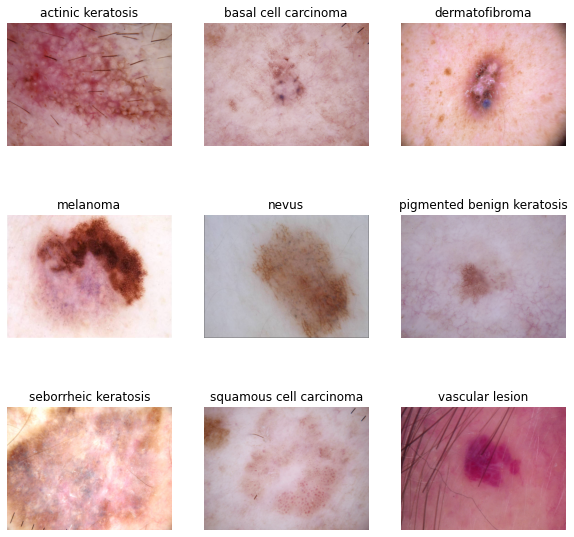

In [10]:
import os
import glob
plt.figure(figsize=(10, 10))
for i, label in enumerate(list(class_names)):
    plt.subplot(3, 3, i+1)
    data_path = os.path.join(str(data_dir_train), label)
    file_path = glob.glob(os.path.join(data_path,'*.jpg'))[0]
    img = PIL.Image.open(file_path)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### **Task 4:  Create the model**

#### **Todo:** Create a CNN model, which can accurately detect 9 classes present in the dataset.


*    Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1)

*   The RGB channel values are in the `[0, 255]` range. 
 

*   This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`



In [12]:
### Your code goes herefrom tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [13]:
###Model Building:
#####Data Sequential -> Rescaling -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Flatten -> Dense -> Dropout -> Dense

model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, (3,3), padding='same',activation='relu'))
#model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3,3), padding='same',activation='relu'))
#model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3,3), padding='same',activation='relu'))
#model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
### Todo, choose an appropirate optimiser and loss function
### Compile Model
model.compile(optimizer='adam',
              loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
281/281 [==============================] - 2550s 2s/step - loss: 1.8693 - accuracy: 0.2901 - val_loss: 1.5410 - val_accuracy: 0.4246
Epoch 2/20
281/281 [==============================] - 7s 24ms/step - loss: 1.4636 - accuracy: 0.4399 - val_loss: 1.6311 - val_accuracy: 0.3907
Epoch 3/20
281/281 [==============================] - 7s 23ms/step - loss: 1.3027 - accuracy: 0.5103 - val_loss: 1.2212 - val_accuracy: 0.5541
Epoch 4/20
281/281 [==============================] - 6s 23ms/step - loss: 1.1741 - accuracy: 0.5549 - val_loss: 0.9967 - val_accuracy: 0.6351
Epoch 5/20
281/281 [==============================] - 6s 23ms/step - loss: 1.0496 - accuracy: 0.6015 - val_loss: 0.9184 - val_accuracy: 0.6524
Epoch 6/20
281/281 [==============================] - 7s 24ms/step - loss: 0.9231 - accuracy: 0.6532 - val_loss: 0.7506 - val_accuracy: 0.7361
Epoch 7/20
281/281 [==============================] - 7s 23ms/step - loss: 0.8296 - accuracy: 0.6856 - val_loss: 0.7298 - val_accuracy: 0.742

### Visualizing training results

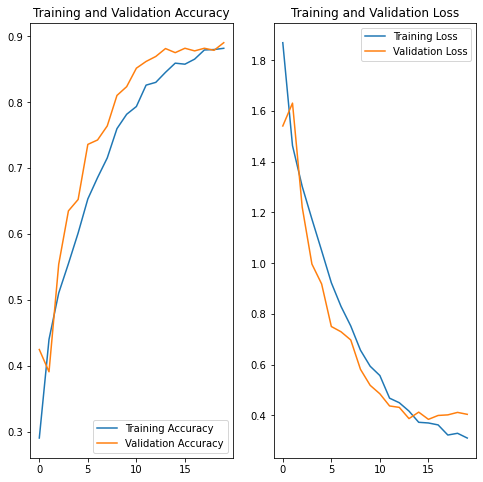

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [18]:
print("Training Accuracy:",history.history['accuracy'][-1])
print("Validation Accuracy:",history.history['val_accuracy'][-1])

Training Accuracy: 0.8820062279701233
Validation Accuracy: 0.8905206918716431


There is significant difference in training accuracy and validation accuracy. This is clear evidence of overfit since the training accuracy is higher than the validation accuracy.

##**Task 5: Data Augmentation**

In [19]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation =  keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

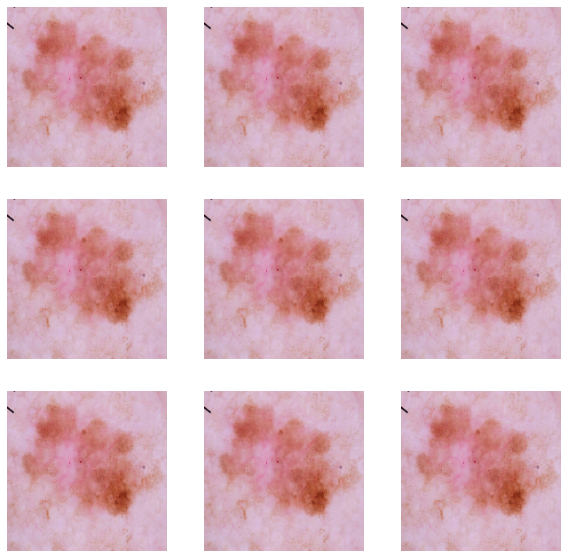

In [20]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


### **Task 6: Create the model, compile and train the model**


In [21]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model_aug = Sequential(data_augmentation)
model_aug.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model_aug.add(Conv2D(16, (3,3), padding='same'))
model_aug.add(Activation('relu'))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))

model_aug.add(Conv2D(32, (3,3), padding='same'))
model_aug.add(Activation('relu'))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))

model_aug.add(Conv2D(64, (3,3), padding='same'))
model_aug.add(Activation('relu'))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))
model_aug.add(Dropout(0.25))

model_aug.add(Flatten())
model_aug.add(Dense(128))
model_aug.add(Activation('relu'))
model_aug.add(Dropout(0.5))
model_aug.add(Dense(num_classes))
model_aug.add(Activation('softmax'))



### Compiling the model

In [22]:
## Your code goes here
### Compile Model
model_aug.compile(optimizer='adam',
              loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])

### Training the model

In [23]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history_aug = model_aug.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
281/281 [==============================] - 9s 26ms/step - loss: 1.8586 - accuracy: 0.2722 - val_loss: 1.5683 - val_accuracy: 0.4054
Epoch 2/20
281/281 [==============================] - 7s 26ms/step - loss: 1.5585 - accuracy: 0.3906 - val_loss: 1.4896 - val_accuracy: 0.4237
Epoch 3/20
281/281 [==============================] - 7s 26ms/step - loss: 1.4598 - accuracy: 0.4230 - val_loss: 1.4119 - val_accuracy: 0.4526
Epoch 4/20
281/281 [==============================] - 7s 26ms/step - loss: 1.4070 - accuracy: 0.4485 - val_loss: 1.2967 - val_accuracy: 0.5047
Epoch 5/20
281/281 [==============================] - 7s 26ms/step - loss: 1.3706 - accuracy: 0.4634 - val_loss: 1.2816 - val_accuracy: 0.5038
Epoch 6/20
281/281 [==============================] - 7s 26ms/step - loss: 1.3309 - accuracy: 0.4733 - val_loss: 1.1886 - val_accuracy: 0.5287
Epoch 7/20
281/281 [==============================] - 7s 26ms/step - loss: 1.2921 - accuracy: 0.4804 - val_loss: 1.2167 - val_accuracy: 0.5171

### Visualizing the results

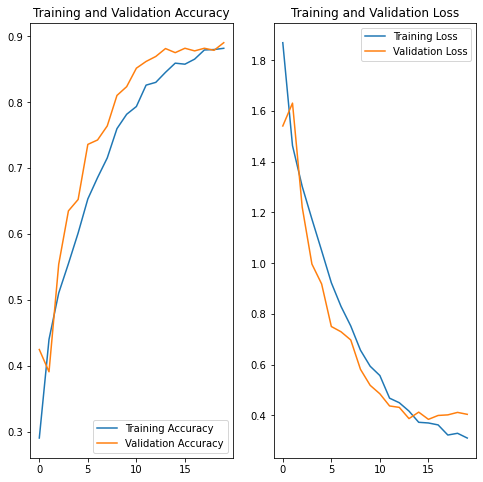

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

In [25]:
print("Training Accuracy:",history_aug.history['accuracy'][-1])
print("Validation Accuracy:",history_aug.history['val_accuracy'][-1])

Training Accuracy: 0.5816280841827393
Validation Accuracy: 0.672007143497467


The training accuracy has reduced significantly but the validation has not changed reasonably and the difference betweent the training accuracy and validation accuracy is very minimal. Thus using image augmentation and Dropout, we have reduced overfitting compared to previous model.

##**Task 7: Class distribution**
#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [26]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
print(len(path_list))

2239


In [27]:
#create the dataframe containing all the path and their labels
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Colab_Notebooks/Melano...,vascular lesion
1,/content/gdrive/MyDrive/Colab_Notebooks/Melano...,vascular lesion
2,/content/gdrive/MyDrive/Colab_Notebooks/Melano...,vascular lesion
3,/content/gdrive/MyDrive/Colab_Notebooks/Melano...,vascular lesion
4,/content/gdrive/MyDrive/Colab_Notebooks/Melano...,vascular lesion
...,...,...
2234,/content/gdrive/MyDrive/Colab_Notebooks/Melano...,squamous cell carcinoma
2235,/content/gdrive/MyDrive/Colab_Notebooks/Melano...,squamous cell carcinoma
2236,/content/gdrive/MyDrive/Colab_Notebooks/Melano...,squamous cell carcinoma
2237,/content/gdrive/MyDrive/Colab_Notebooks/Melano...,squamous cell carcinoma


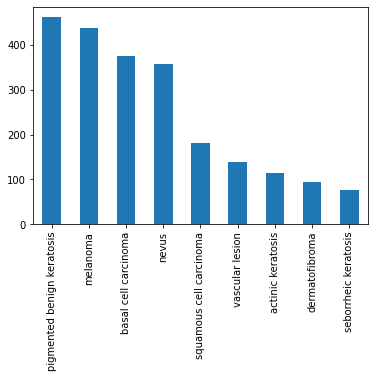

In [28]:
## Visualising the distribution of each labels from the dataframe

original_df["Label"].value_counts().plot(kind = 'bar')

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?

1. Seborrheic Keratosis has the least number of samples.
2. Pigmented benign keratosis, melanoma and basal cell carcinoma has the highest proportion of data


## **Task 8: Rectify the class imbalance**
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [29]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [30]:
path_to_training_dataset="/content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F400084AC90>: 100%|██████████| 500/500 [00:20<00:00, 24.60 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4002120C50>: 100%|██████████| 500/500 [00:21<00:00, 23.36 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F40023E3510>: 100%|██████████| 500/500 [00:21<00:00, 23.38 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F4000BC0510>: 100%|██████████| 500/500 [01:27<00:00,  5.71 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F4016025090>: 100%|██████████| 500/500 [01:23<00:00,  5.98 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4001F7E990>: 100%|██████████| 500/500 [00:18<00:00, 27.52 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F4002029510>: 100%|██████████| 500/500 [00:40<00:00, 12.25 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4002095910>: 100%|██████████| 500/500 [00:17<00:00, 27.95 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4016025090>: 100%|██████████| 500/500 [00:17<00:00, 28.04 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [31]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

13500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [32]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/Train/vascular lesion/output/vascular lesion_original_ISIC_0033031.jpg_eef8943f-2395-4e5f-b48b-676ec0328009.jpg',
 '/content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/Train/vascular lesion/output/vascular lesion_original_ISIC_0026163.jpg_f3ea6ab2-5e51-4711-8235-242b6fdff5a6.jpg',
 '/content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/Train/vascular lesion/output/vascular lesion_original_ISIC_0024706.jpg_b5cbae27-5b84-46b1-bb87-7df2556d9596.jpg',
 '/content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/Train/vascular lesion/output/vascular lesion_original_ISIC_0028406.jpg_68ad4c24-1a6a-4f5d-8d9a-52c3161827a3.jpg',
 '/content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/Train/vascular lesion/output/vascular lesion_original_ISIC_0026490.jpg_6b6f99bc-8e2c-4cc2-a742-8a56a3c6b4d5.jpg',
 '/content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignmen

In [33]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/Train/vascular lesion/output/vascular lesion_original_ISIC_0033031.jpg_eef8943f-2395-4e5f-b48b-676ec0328009.jpg',
 '/content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/Train/vascular lesion/output/vascular lesion_original_ISIC_0026163.jpg_f3ea6ab2-5e51-4711-8235-242b6fdff5a6.jpg',
 '/content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/Train/vascular lesion/output/vascular lesion_original_ISIC_0024706.jpg_b5cbae27-5b84-46b1-bb87-7df2556d9596.jpg',
 '/content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/Train/vascular lesion/output/vascular lesion_original_ISIC_0028406.jpg_68ad4c24-1a6a-4f5d-8d9a-52c3161827a3.jpg',
 '/content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignment/Train/vascular lesion/output/vascular lesion_original_ISIC_0026490.jpg_6b6f99bc-8e2c-4cc2-a742-8a56a3c6b4d5.jpg',
 '/content/gdrive/MyDrive/Colab_Notebooks/Melanoma_Detection_Assignmen

In [34]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [35]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [36]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [37]:
new_df['Label'].value_counts()

pigmented benign keratosis    1962
melanoma                      1938
basal cell carcinoma          1876
nevus                         1857
squamous cell carcinoma       1681
vascular lesion               1639
actinic keratosis             1614
dermatofibroma                1595
seborrheic keratosis          1577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

##**Task9: Model Building & training**

#### **Todo**: Train the model on the data created using Augmentor

In [38]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [39]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15739 files belonging to 9 classes.
Using 12592 files for training.


#### **Todo:** Create a validation dataset

In [40]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15739 files belonging to 9 classes.
Using 3147 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [41]:
## your code goes here
model_aug_classimb = Sequential(data_augmentation)
model_aug_classimb.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model_aug_classimb.add(Conv2D(16, (3,3), padding='same'))
model_aug_classimb.add(Activation('relu'))
model_aug_classimb.add(MaxPooling2D(pool_size=(2, 2)))

model_aug_classimb.add(Conv2D(32, (3,3), padding='same'))
model_aug_classimb.add(Activation('relu'))
model_aug_classimb.add(MaxPooling2D(pool_size=(2, 2)))

model_aug_classimb.add(Conv2D(64, (3,3), padding='same'))
model_aug_classimb.add(Activation('relu'))
model_aug_classimb.add(MaxPooling2D(pool_size=(2, 2)))
model_aug_classimb.add(Dropout(0.25))

model_aug_classimb.add(Flatten())
model_aug_classimb.add(Dense(128))
model_aug_classimb.add(Activation('relu'))
model_aug_classimb.add(Dropout(0.5))
model_aug_classimb.add(Dense(num_classes))
model_aug_classimb.add(Activation('softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [42]:
## your code goes here
model_aug_classimb.compile(optimizer='adam',
              loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])

In [43]:
model_aug_classimb.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 activation_7 (Activation)   (None, 180, 180, 16)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                      

#### **Todo:**  Train your model

In [44]:
epochs = 30

history_aug_classimb = model_aug_classimb.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
394/394 [==============================] - 79s 195ms/step - loss: 1.9980 - accuracy: 0.2174 - val_loss: 1.4769 - val_accuracy: 0.4334
Epoch 2/30
394/394 [==============================] - 64s 161ms/step - loss: 1.4931 - accuracy: 0.4165 - val_loss: 1.2973 - val_accuracy: 0.5078
Epoch 3/30
394/394 [==============================] - 60s 150ms/step - loss: 1.4015 - accuracy: 0.4530 - val_loss: 1.2243 - val_accuracy: 0.5195
Epoch 4/30
394/394 [==============================] - 60s 151ms/step - loss: 1.3183 - accuracy: 0.4891 - val_loss: 1.1817 - val_accuracy: 0.5580
Epoch 5/30
394/394 [==============================] - 62s 155ms/step - loss: 1.2608 - accuracy: 0.5053 - val_loss: 1.1846 - val_accuracy: 0.5462
Epoch 6/30
394/394 [==============================] - 61s 151ms/step - loss: 1.2129 - accuracy: 0.5287 - val_loss: 1.0822 - val_accuracy: 0.5815
Epoch 7/30
394/394 [==============================] - 60s 151ms/step - loss: 1.1842 - accuracy: 0.5441 - val_loss: 0.9994 - val_ac

#### **Todo:**  Visualize the model results

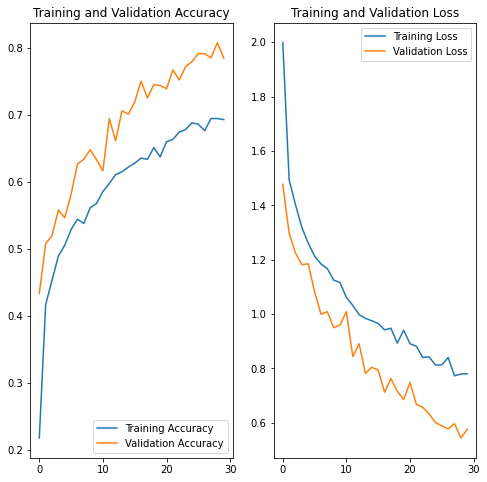

In [45]:
acc = history_aug_classimb.history['accuracy']
val_acc = history_aug_classimb.history['val_accuracy']

loss = history_aug_classimb.history['loss']
val_loss = history_aug_classimb.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. 
 

*   Did you get rid of underfitting/overfitting?
*   Did class rebalance help?





In [46]:
print("Training Accuracy:",history_aug_classimb.history['accuracy'][-1])
print("Validation Accuracy:",history_aug_classimb.history['val_accuracy'][-1])

Training Accuracy: 0.6928208470344543
Validation Accuracy: 0.7845567464828491
